# ⚽ Football Matches 2024/2025 — Exploratory Data Analysis

### **Football Matches 2024/2025 dataset**, covering multiple competitions, teams, scores, and match outcomes.



# Imports

In [585]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from calendar import month_name
from IPython.display import display

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12,6)
sns.set_palette("Set2")

# Load Data


In [ ]:
df = pd.read_csv("/kaggle/input/football-matches-20242025-top-5-leagues/football_matches_2024_2025.csv")

# Dataset Overview

In [587]:
print("Shape:", df.shape)
display(df.head())
df.info()



Shape: (1941, 23)


,competition_code,competition_name,season,match_id,matchday,stage,status,date_utc,referee,home_team_id,...,fulltime_home,fulltime_away,halftime_home,halftime_away,goal_difference,total_goals,match_outcome,home_points,away_points,date_local_africa_cairo
0,PL,Premier League,2024/2025,497410,1,REGULAR_SEASON,FINISHED,2024-08-16 19:00:00+00:00,Robert Jones,66,...,1,0,0.0,0.0,1,1,Home Win,3,0,2024-08-16 22:00
1,PL,Premier League,2024/2025,497411,1,REGULAR_SEASON,FINISHED,2024-08-17 11:30:00+00:00,Tim Robinson,349,...,0,2,0.0,0.0,-2,2,Away Win,0,3,2024-08-17 14:30
2,PL,Premier League,2024/2025,497412,1,REGULAR_SEASON,FINISHED,2024-08-17 14:00:00+00:00,Jarred Gillett,57,...,2,0,1.0,0.0,2,2,Home Win,3,0,2024-08-17 17:00
3,PL,Premier League,2024/2025,497413,1,REGULAR_SEASON,FINISHED,2024-08-17 14:00:00+00:00,Simon Hooper,62,...,0,3,0.0,1.0,-3,3,Away Win,0,3,2024-08-17 17:00
4,PL,Premier League,2024/2025,497414,1,REGULAR_SEASON,FINISHED,2024-08-17 14:00:00+00:00,Craig Pawson,67,...,1,0,1.0,0.0,1,1,Home Win,3,0,2024-08-17 17:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   competition_code         1941 non-null   object 
 1   competition_name         1941 non-null   object 
 2   season                   1941 non-null   object 
 3   match_id                 1941 non-null   int64  
 4   matchday                 1941 non-null   int64  
 5   stage                    1941 non-null   object 
 6   status                   1941 non-null   object 
 7   date_utc                 1941 non-null   object 
 8   referee                  1938 non-null   object 
 9   home_team_id             1941 non-null   int64  
 10  home_team                1941 non-null   object 
 11  away_team_id             1941 non-null   int64  
 12  away_team                1941 non-null   object 
 13  fulltime_home            1941 non-null   int64  
 14  fulltime_away           

# Clean Data

In [588]:
print("Missing values per column before cleaning:")
print(df.isna().sum())

# Fill missing referee names with "Unknown"
if "referee" in df.columns:
    df["referee"] = df["referee"].fillna("Unknown")

# Only finished matches (require full-time score)
df = df.dropna(subset=["fulltime_home", "fulltime_away"])


# Parse date once & sort
df["date"] = pd.to_datetime(df["date_utc"])
df = df.sort_values("date").reset_index(drop=True)

# Remove duplicates
df = df.drop_duplicates()

print("\nAfter cleaning:")
print(df.isna().sum().sort_values(ascending=False))
print("Shape:", df.shape)

Missing values per column before cleaning:
competition_code           0
competition_name           0
season                     0
match_id                   0
matchday                   0
stage                      0
status                     0
date_utc                   0
referee                    3
home_team_id               0
home_team                  0
away_team_id               0
away_team                  0
fulltime_home              0
fulltime_away              0
halftime_home              1
halftime_away              1
goal_difference            0
total_goals                0
match_outcome              0
home_points                0
away_points                0
date_local_africa_cairo    0
dtype: int64

After cleaning:
halftime_away              1
halftime_home              1
competition_code           0
competition_name           0
matchday                   0
stage                      0
season                     0
match_id                   0
date_utc                   0

# Feature Engineering

In [589]:
df["TotalGoals"] = df["fulltime_home"] + df["fulltime_away"]
df["GoalDiff"]   = df["fulltime_home"] - df["fulltime_away"]

# Points
df["home_points"] = np.where(df["fulltime_home"] > df["fulltime_away"], 3,
                      np.where(df["fulltime_home"] == df["fulltime_away"], 1, 0))
df["away_points"] = np.where(df["fulltime_away"] > df["fulltime_home"], 3,
                      np.where(df["fulltime_home"] == df["fulltime_away"], 1, 0))

# Outcomes flags
df["is_home_win"] = (df["fulltime_home"] > df["fulltime_away"]).astype(int)
df["is_draw"]     = (df["fulltime_home"] == df["fulltime_away"]).astype(int)
df["is_away_win"] = (df["fulltime_away"] > df["fulltime_home"]).astype(int)

# Betting-style quick features
df["BTTS"]    = ((df["fulltime_home"] > 0) & (df["fulltime_away"] > 0)).astype(int)
df["Over2_5"] = (df["TotalGoals"] > 2.5).astype(int)

# Time features (ordered months & weekdays)
df["month"]   = df["date"].dt.month_name()
df["weekday"] = df["date"].dt.day_name()

months = list(month_name)[1:]  # Jan..Dec
df["month"] = pd.Categorical(df["month"], categories=months, ordered=True)

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=weekday_order, ordered=True)

# Labels
df["scoreline"] = df["fulltime_home"].astype(str) + "-" + df["fulltime_away"].astype(str)

# clean sheets
df["home_cs"] = (df["fulltime_away"] == 0).astype(int)
df["away_cs"] = (df["fulltime_home"] == 0).astype(int)

# Small helper: wrap long x tick labels
def wrap_labels(ax, width=14):
    new_labels = []
    for l in ax.get_xticklabels():
        text = l.get_text()
        new_labels.append("\n".join([text[i:i+width] for i in range(0, len(text), width)]))
    ax.set_xticklabels(new_labels, rotation=0)


# EDA


## Matches per Competition

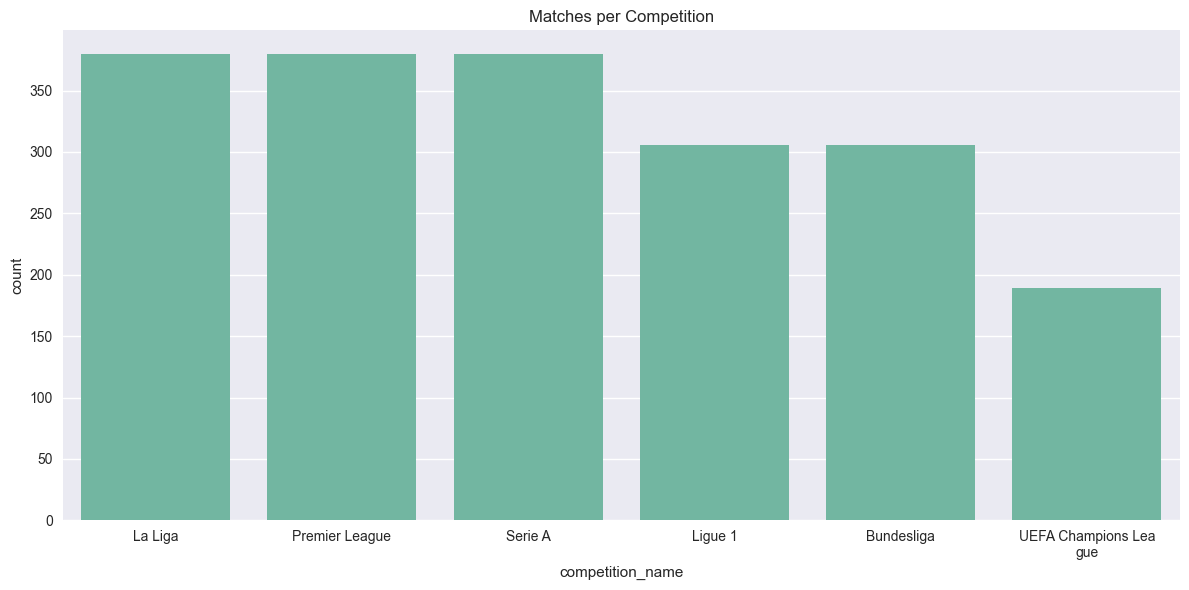

In [590]:
order_comp_count = df["competition_name"].value_counts().index
ax = sns.countplot(data=df, x="competition_name", order=order_comp_count)
plt.title("Matches per Competition")
plt.xticks(rotation=0)
wrap_labels(ax, width=18)
plt.tight_layout()
plt.show()


## Outcomes (overall)

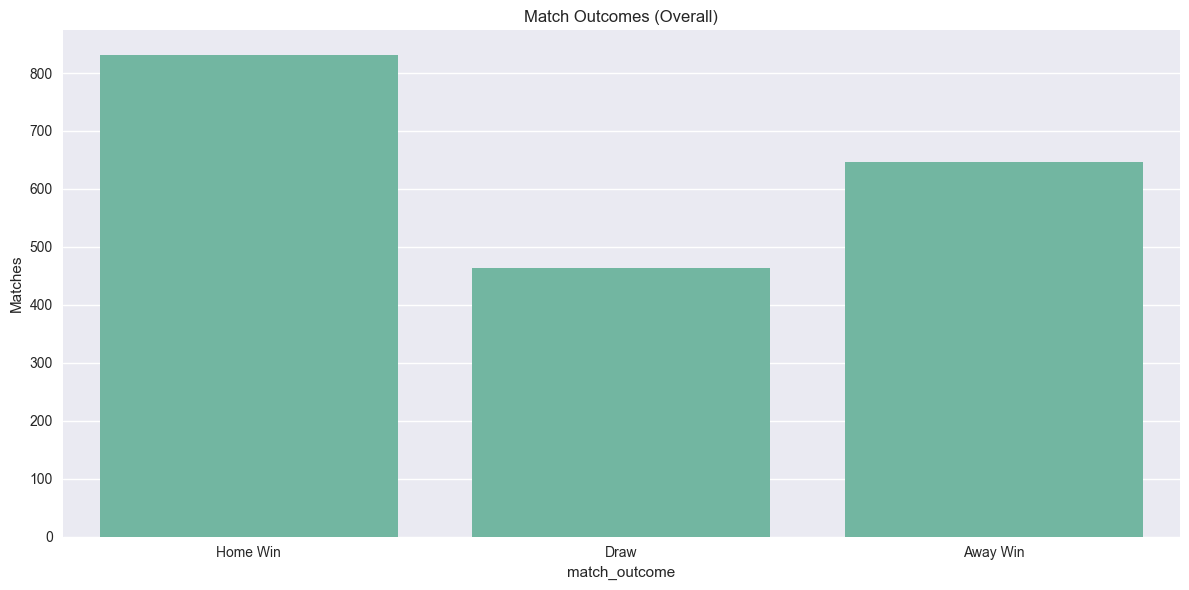

In [591]:
outcome_order = [c for c in ["Home Win", "Draw", "Away Win"] if c in df["match_outcome"].unique()]
ax = sns.countplot(data=df, x="match_outcome", order=outcome_order)
plt.title("Match Outcomes (Overall)"); plt.ylabel("Matches")
plt.tight_layout()
plt.show()


## Goals Distribution

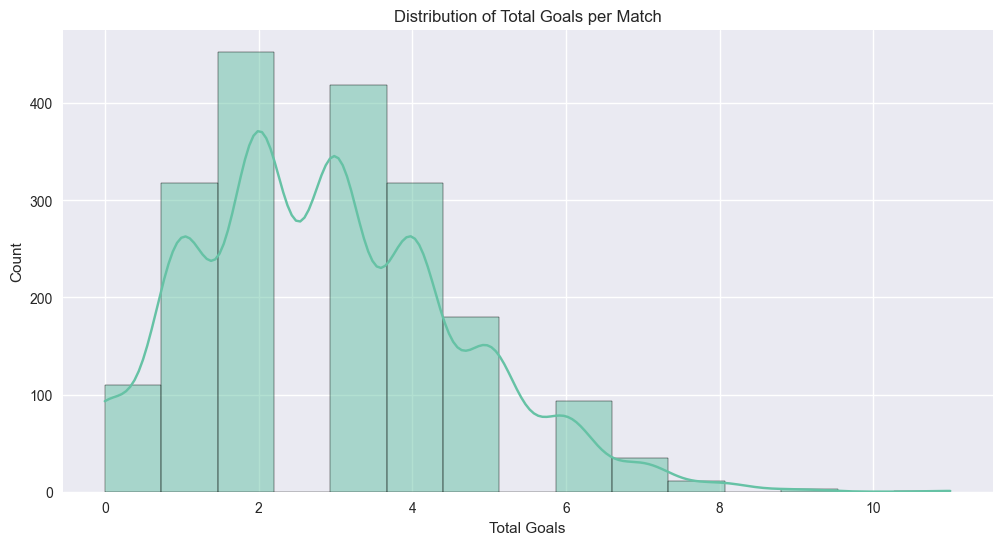

In [592]:
sns.histplot(df["TotalGoals"], bins=15, kde=True)
plt.title("Distribution of Total Goals per Match"); plt.xlabel("Total Goals")
plt.show()

## FacetGrid Total Goals Distribution — per Competition

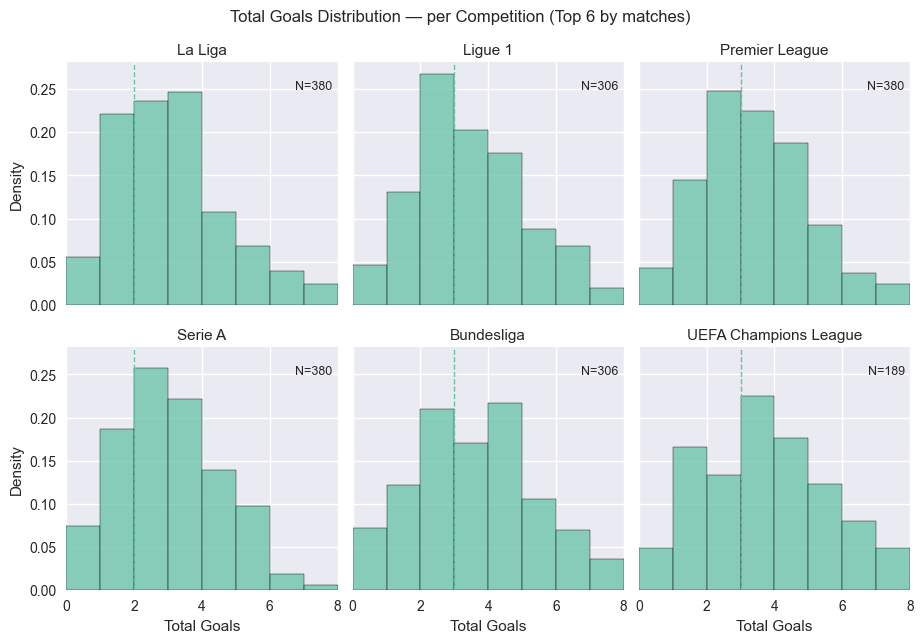

In [593]:
comp_counts = df["competition_name"].value_counts()
TOPN = 6
top_comps = comp_counts.head(TOPN).index
sub = df[df["competition_name"].isin(top_comps)].copy()

# FacetGrid with unified bins/axes + median line + N
xmax = int(np.quantile(df["TotalGoals"], 0.99)) + 1
bins = np.arange(0, max(7, xmax)+1)

def facet_hist(data, color=None, **kws):
    ax = plt.gca()
    sns.histplot(data=data, x="TotalGoals", bins=bins, stat="density", ax=ax, color=color)
    med = data["TotalGoals"].median()
    ax.axvline(med, ls="--", lw=1)
    ax.text(0.98, 0.9, f"N={len(data)}", transform=ax.transAxes, ha="right", va="center", fontsize=9)

g = sns.FacetGrid(sub, col="competition_name", col_wrap=3, sharex=True, sharey=True, height=3.1)
g.map_dataframe(facet_hist)
g.set_titles("{col_name}")
g.set_xlabels("Total Goals"); g.set_ylabels("Density")
g.set(xlim=(0, bins.max()))
plt.suptitle("Total Goals Distribution — per Competition (Top 6 by matches)", y=1.03)
plt.show()


## Boxplot summary across all competition

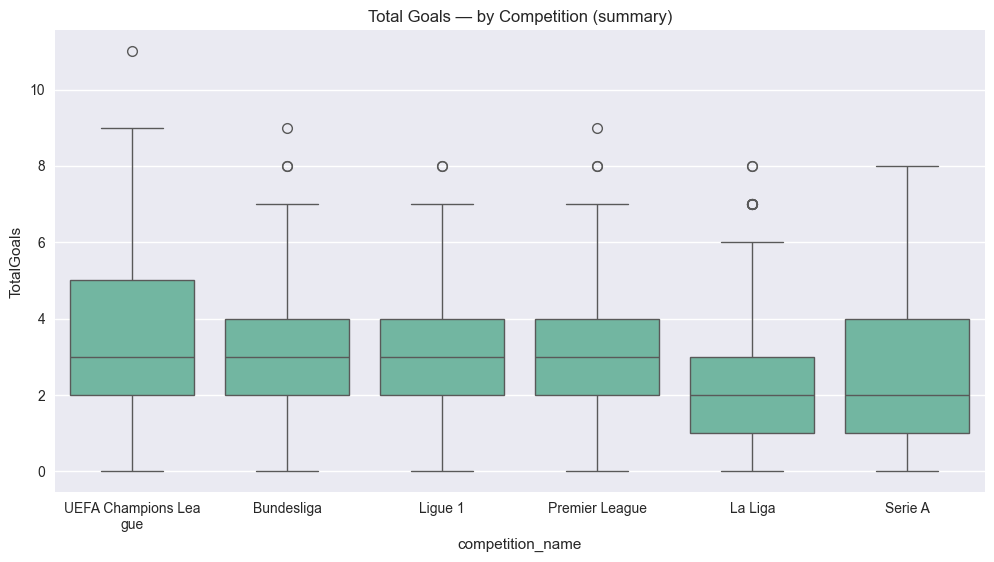

In [594]:
order_comp = df.groupby("competition_name")["TotalGoals"].mean().sort_values(ascending=False).index
sns.boxplot(data=df, x="competition_name", y="TotalGoals", order=order_comp)
plt.xticks(rotation=45); wrap_labels(plt.gca(), width=18)
plt.title("Total Goals — by Competition (summary)")
plt.show()

## Avg Goals & BTTS (side-by-side)

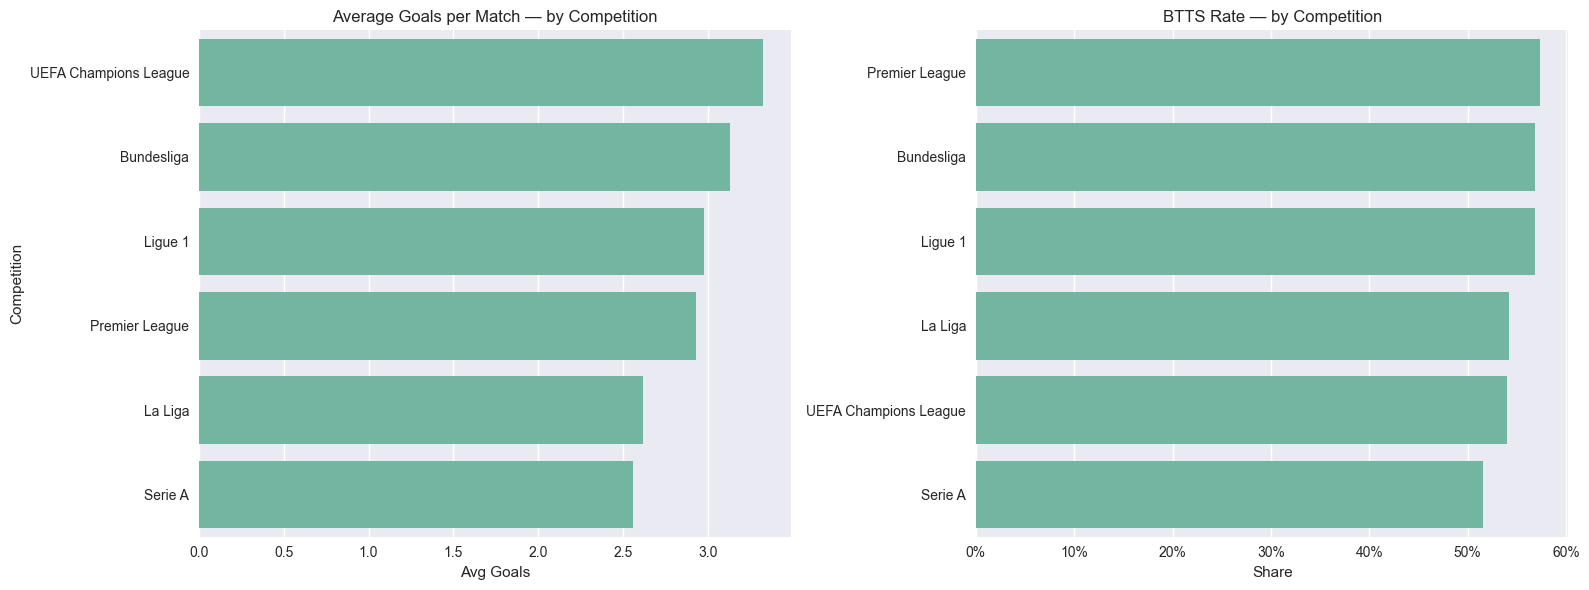

In [595]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

avg_goals = df.groupby("competition_name")["TotalGoals"].mean().sort_values(ascending=False)
sns.barplot(x=avg_goals.values, y=avg_goals.index, ax=axes[0])
axes[0].set_title("Average Goals per Match — by Competition")
axes[0].set_xlabel("Avg Goals"); axes[0].set_ylabel("Competition")

btts_rate = df.groupby("competition_name")["BTTS"].mean().sort_values(ascending=False)
sns.barplot(x=btts_rate.values, y=btts_rate.index, ax=axes[1])
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].set_title("BTTS Rate — by Competition")
axes[1].set_xlabel("Share"); axes[1].set_ylabel("")

plt.tight_layout(); plt.show()

## Home Advantage (Home win rate)

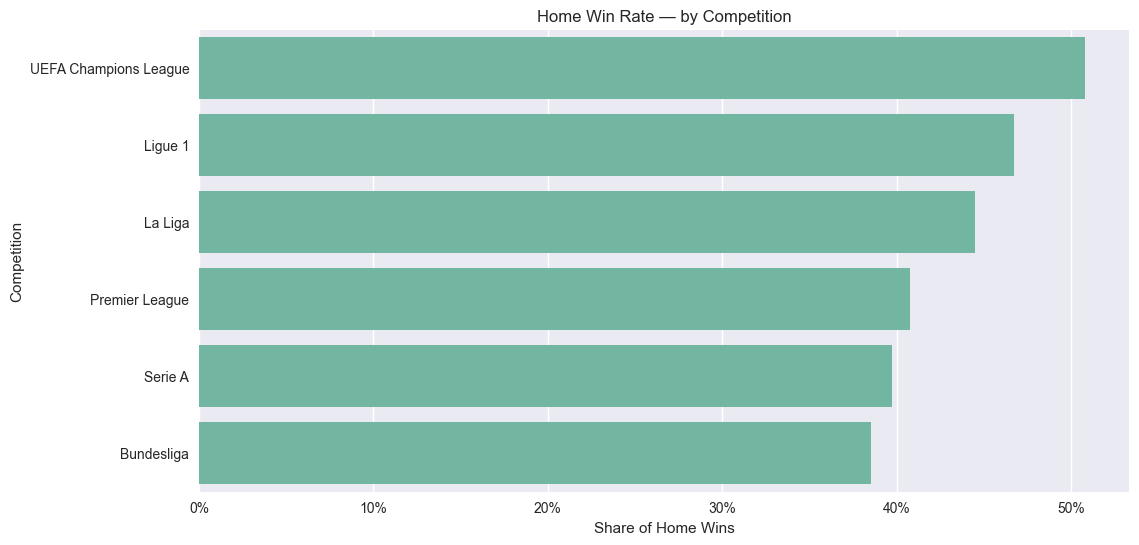

In [596]:
home_adv = df.groupby("competition_name")["is_home_win"].mean().sort_values(ascending=False)
ax = sns.barplot(x=home_adv.values, y=home_adv.index)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Home Win Rate — by Competition"); plt.xlabel("Share of Home Wins"); plt.ylabel("Competition")
plt.show()

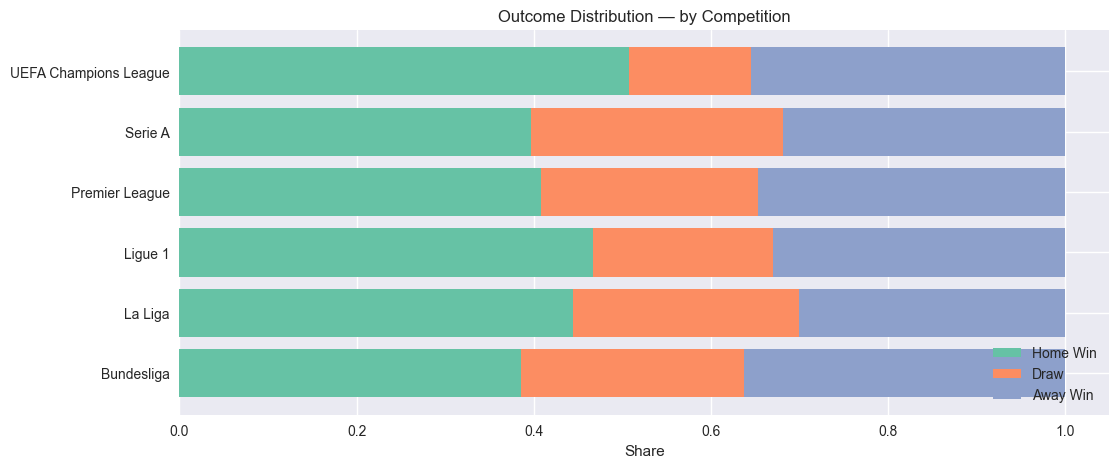

In [597]:
out = pd.crosstab(df["competition_name"], df["match_outcome"], normalize="index").fillna(0)
order_cols = [c for c in ["Home Win","Draw","Away Win"] if c in out.columns]
if order_cols:
    out = out[order_cols]

plt.figure(figsize=(12, max(5, 0.4*len(out))))
bottom = np.zeros(len(out))
for col in out.columns:
    plt.barh(out.index, out[col].values, left=bottom, label=col)
    bottom += out[col].values
plt.title("Outcome Distribution — by Competition")
plt.xlabel("Share"); plt.legend(loc="lower right")
plt.show()

## Matches over Time

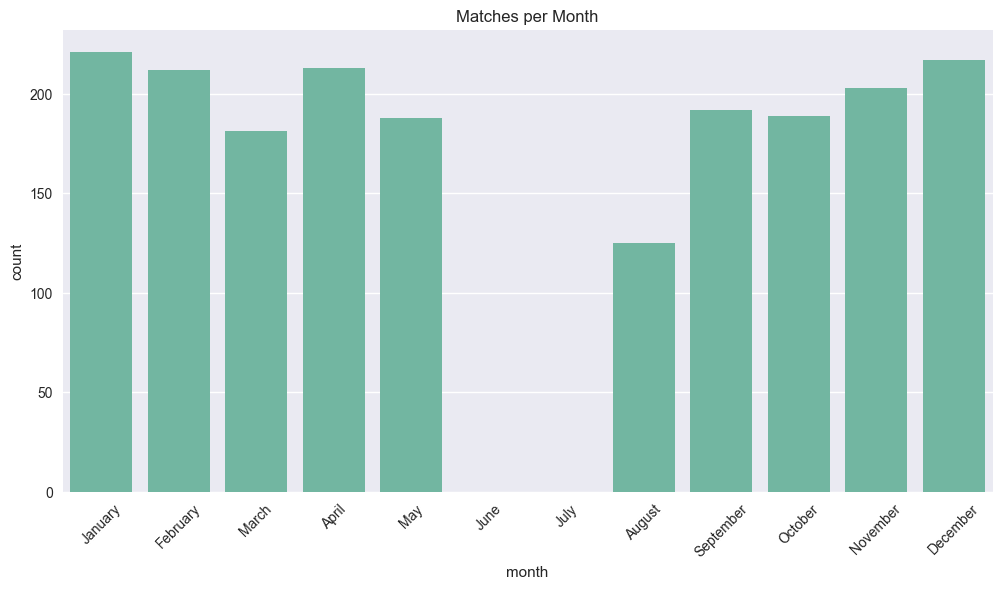

In [598]:
ax = sns.countplot(data=df, x="month", order=months)
plt.title("Matches per Month"); plt.xticks(rotation=45)
plt.show()

## Weekly Matches & Avg Goals (twin axis)

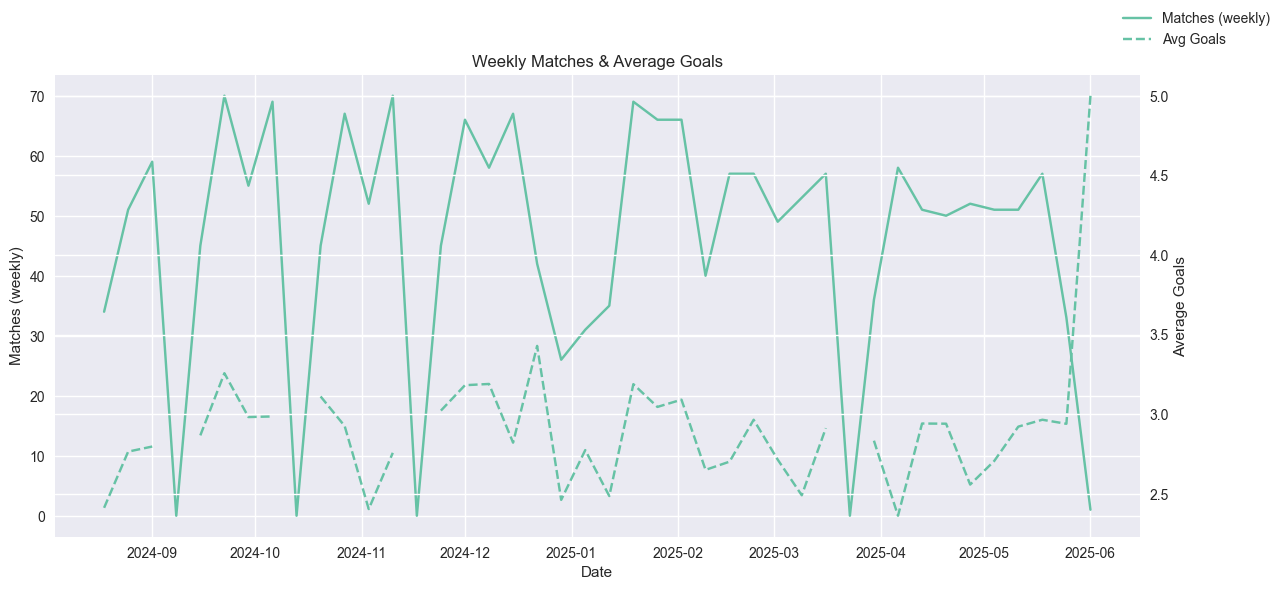

In [599]:
weekly = df.resample("W", on="date").agg(
    matches=("match_outcome","count"),
    avg_goals=("TotalGoals","mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(14,6)); ax2 = ax1.twinx()
ax1.plot(weekly["date"], weekly["matches"], label="Matches (weekly)")
ax2.plot(weekly["date"], weekly["avg_goals"], label="Avg Goals", linestyle="--")
ax1.set_title("Weekly Matches & Average Goals"); ax1.set_xlabel("Date")
ax1.set_ylabel("Matches (weekly)"); ax2.set_ylabel("Average Goals")
fig.legend(loc="upper right"); plt.show()


## Over 2.5 by Month

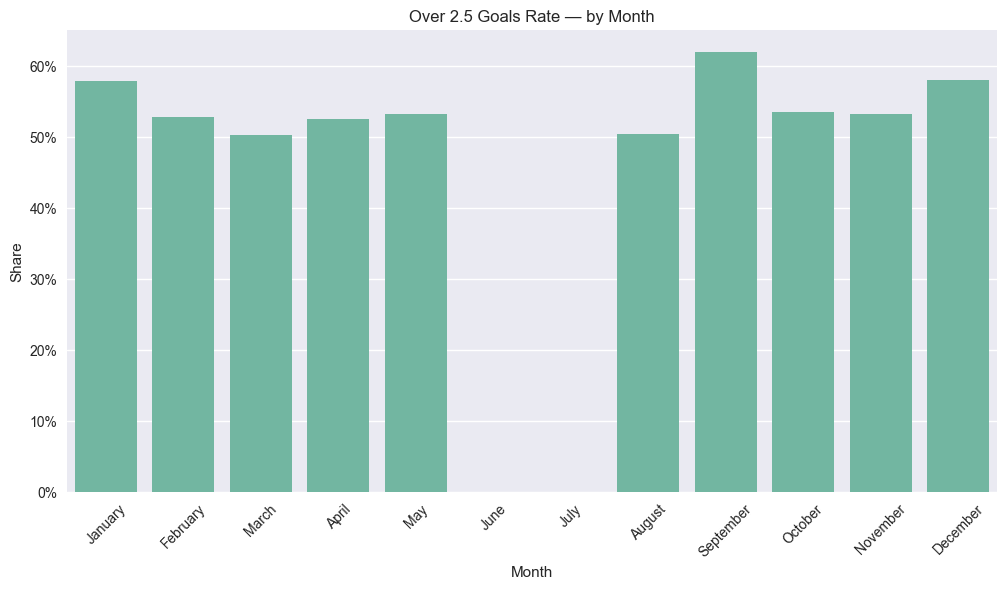

In [600]:
over_rate_month = df.groupby("month")["Over2_5"].mean().reindex(months)
ax = sns.barplot(x=over_rate_month.index, y=over_rate_month.values)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Over 2.5 Goals Rate — by Month"); plt.xlabel("Month"); plt.ylabel("Share")
plt.xticks(rotation=45); plt.show()

## BTTS by Month

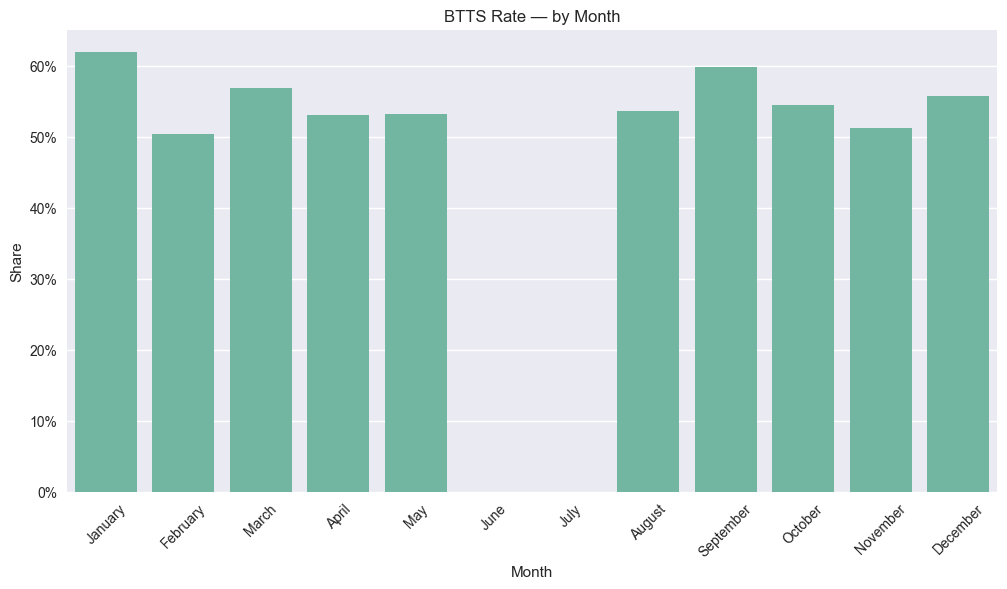

In [601]:
btts_rate_month = df.groupby("month")["BTTS"].mean().reindex(months)
ax = sns.barplot(x=btts_rate_month.index, y=btts_rate_month.values)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("BTTS Rate — by Month"); plt.xlabel("Month"); plt.ylabel("Share")
plt.xticks(rotation=45); plt.show()


## Outcome Share by Month (Heatmap)

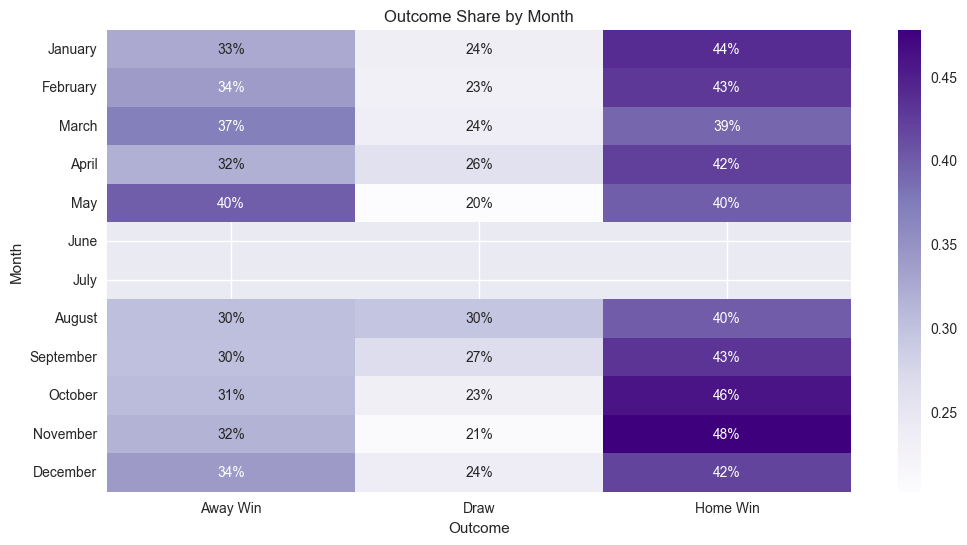

In [602]:
tab_m = pd.crosstab(df["month"], df["match_outcome"], normalize="index").fillna(0).reindex(months)
sns.heatmap(tab_m, annot=True, fmt=".0%", cmap="Purples")
plt.title("Outcome Share by Month"); plt.xlabel("Outcome"); plt.ylabel("Month")
plt.show()


## Rolling 4-week Outcome Shares

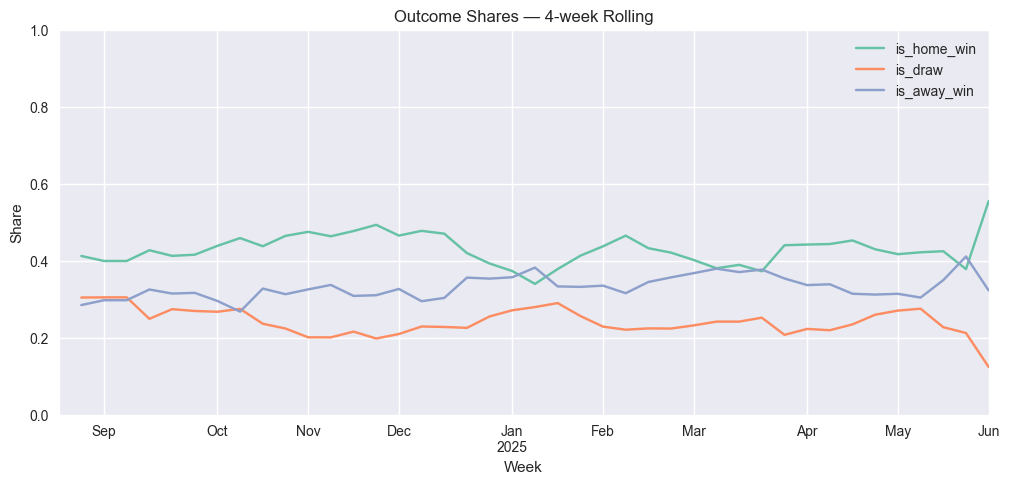

In [603]:
wk = df.resample("W", on="date")[["is_home_win","is_draw","is_away_win"]].mean()
wk_roll = wk.rolling(4, min_periods=2).mean()
wk_roll.plot(figsize=(12,5))
plt.ylim(0,1); plt.title("Outcome Shares — 4-week Rolling"); plt.xlabel("Week"); plt.ylabel("Share")
plt.show()


## Top 10 Teams by Total Goals vs Bottom 10 Teams by Total Goals

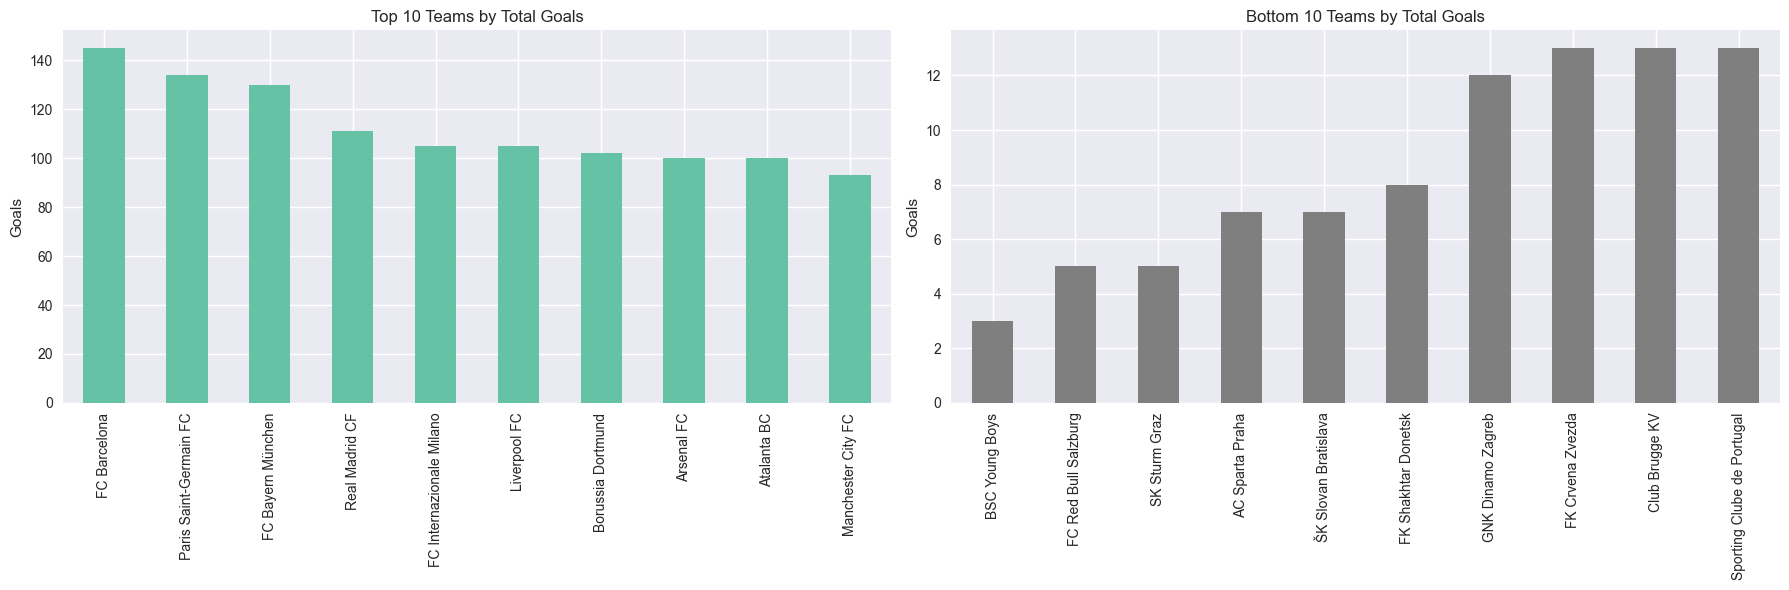

In [604]:
team_goals_home = df.groupby("home_team")["fulltime_home"].sum().rename("home_goals")
team_goals_away = df.groupby("away_team")["fulltime_away"].sum().rename("away_goals")
team_goals = pd.concat([team_goals_home, team_goals_away], axis=1).fillna(0)
team_goals["total"] = team_goals["home_goals"] + team_goals["away_goals"]

top10 = team_goals.sort_values("total", ascending=False).head(10)
bot10 = team_goals.sort_values("total", ascending=True).head(10)

fig, ax = plt.subplots(1,2, figsize=(18,6))
top10["total"].plot(kind="bar", ax=ax[0], title="Top 10 Teams by Total Goals"); ax[0].set_ylabel("Goals")
bot10["total"].plot(kind="bar", ax=ax[1], title="Bottom 10 Teams by Total Goals", color="tab:gray"); ax[1].set_ylabel("Goals")
plt.tight_layout(); plt.show()


## Points per Game (PPG) — Top 15 (min 10 matches)

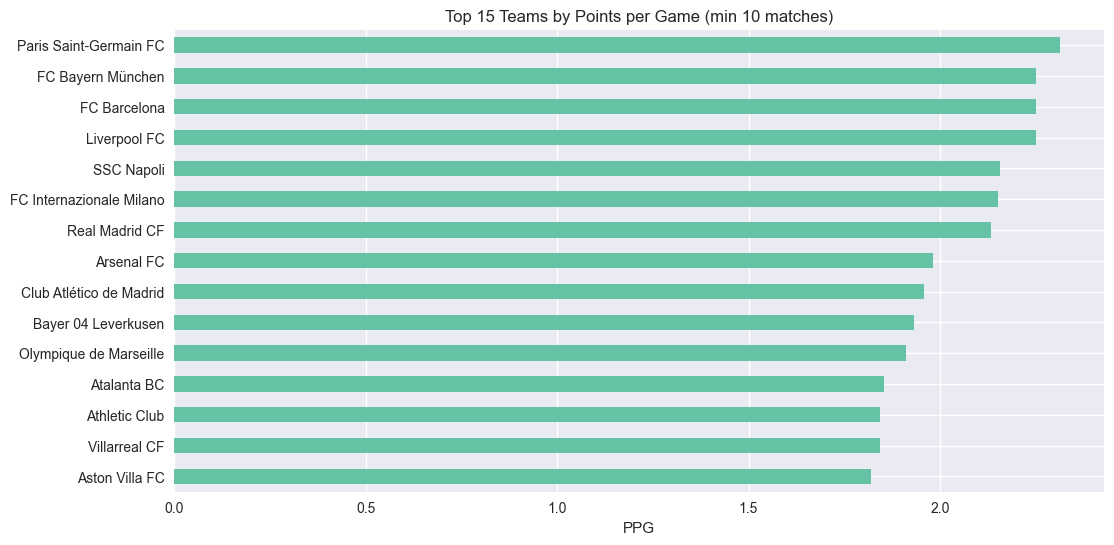

In [605]:
home_part = df[["date","competition_name","home_team","home_points"]].rename(
    columns={"home_team":"team","home_points":"points"})
away_part = df[["date","competition_name","away_team","away_points"]].rename(
    columns={"away_team":"team","away_points":"points"})
team_matches = pd.concat([home_part, away_part], axis=0, ignore_index=True)

ppg = (team_matches.groupby("team")
       .agg(matches=("points","count"), ppg=("points","mean"))
       .sort_values("ppg", ascending=False))

ppg_plot = ppg.query("matches >= 10").head(15).sort_values("ppg", ascending=True)
ppg_plot["ppg"].plot(kind="barh")
plt.title("Top 15 Teams by Points per Game (min 10 matches)"); plt.xlabel("PPG"); plt.ylabel("")
plt.show()


## Home vs Away PPG

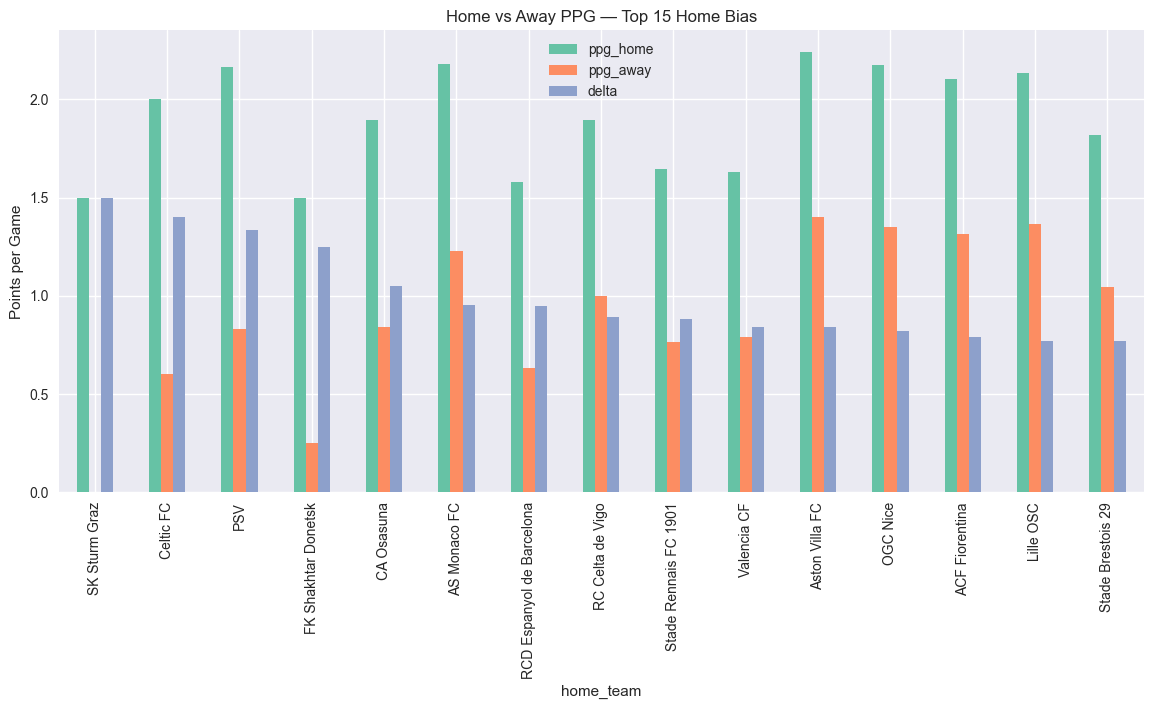

In [606]:
home_ppg = (df.groupby("home_team")["home_points"].agg(["sum","count"]).rename(columns={"sum":"pts","count":"gp"}))
home_ppg["ppg_home"] = home_ppg["pts"] / home_ppg["gp"]

away_ppg = (df.groupby("away_team")["away_points"].agg(["sum","count"]).rename(columns={"sum":"pts","count":"gp"}))
away_ppg["ppg_away"] = away_ppg["pts"] / away_ppg["gp"]

ppg_side = (home_ppg[["ppg_home"]].join(away_ppg[["ppg_away"]], how="outer").fillna(0))
ppg_side["delta"] = ppg_side["ppg_home"] - ppg_side["ppg_away"]

ppg_side.sort_values("delta", ascending=False).head(15)[["ppg_home","ppg_away","delta"]].plot(
    kind="bar", figsize=(14,6), title="Home vs Away PPG — Top 15 Home Bias"
)
plt.ylabel("Points per Game"); plt.show()


## Scoreline Heatmap

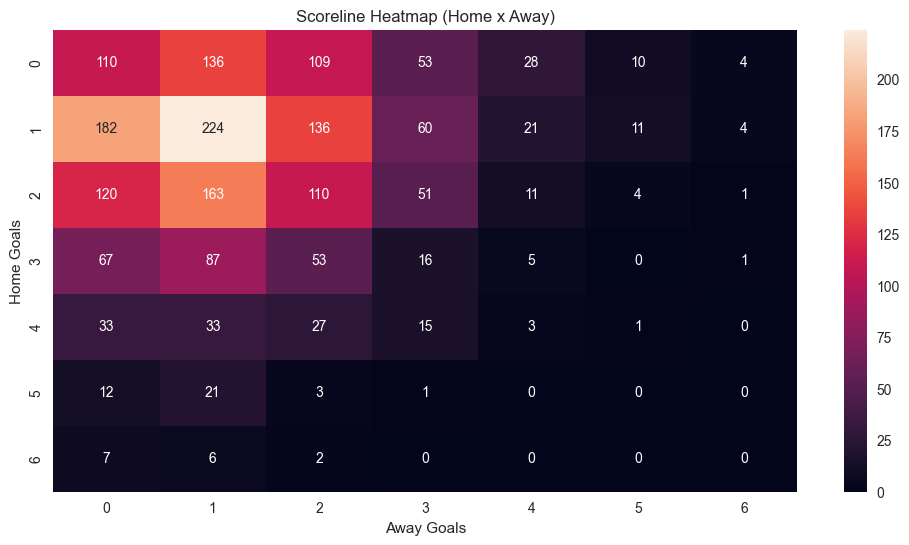

In [607]:
clip = df.copy()
clip["H"] = clip["fulltime_home"].clip(0,6)
clip["A"] = clip["fulltime_away"].clip(0,6)
mat = pd.crosstab(clip["H"], clip["A"])

sns.heatmap(mat, annot=True, fmt="d")
plt.title("Scoreline Heatmap (Home x Away)"); plt.xlabel("Away Goals"); plt.ylabel("Home Goals")
plt.show()


## Top Scorelines

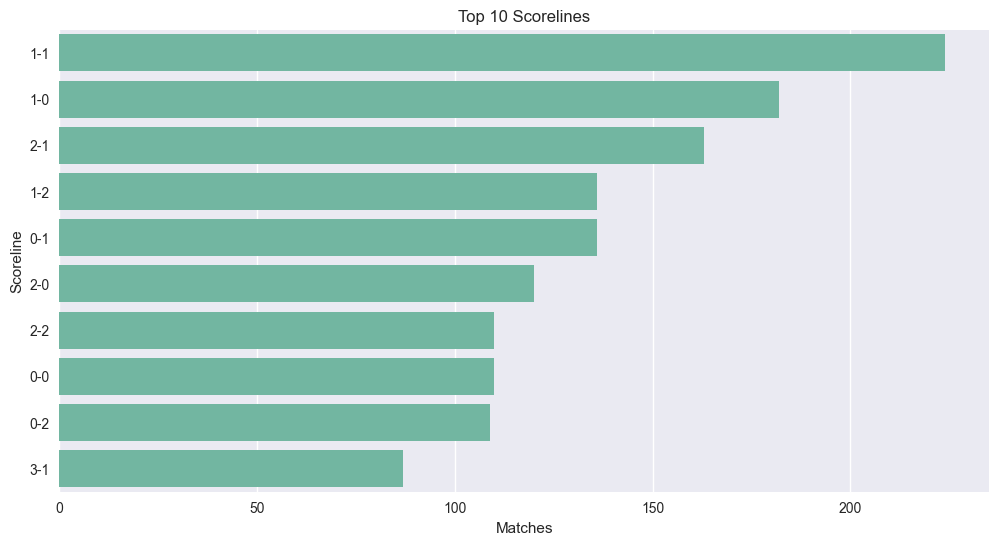

In [608]:
top_scores = df["scoreline"].value_counts().head(10)
sns.barplot(x=top_scores.values, y=top_scores.index)
plt.title("Top 10 Scorelines"); plt.xlabel("Matches"); plt.ylabel("Scoreline")
plt.show()

## Matches per Referee + Avg Goals per Referee for Top Refs by Matches

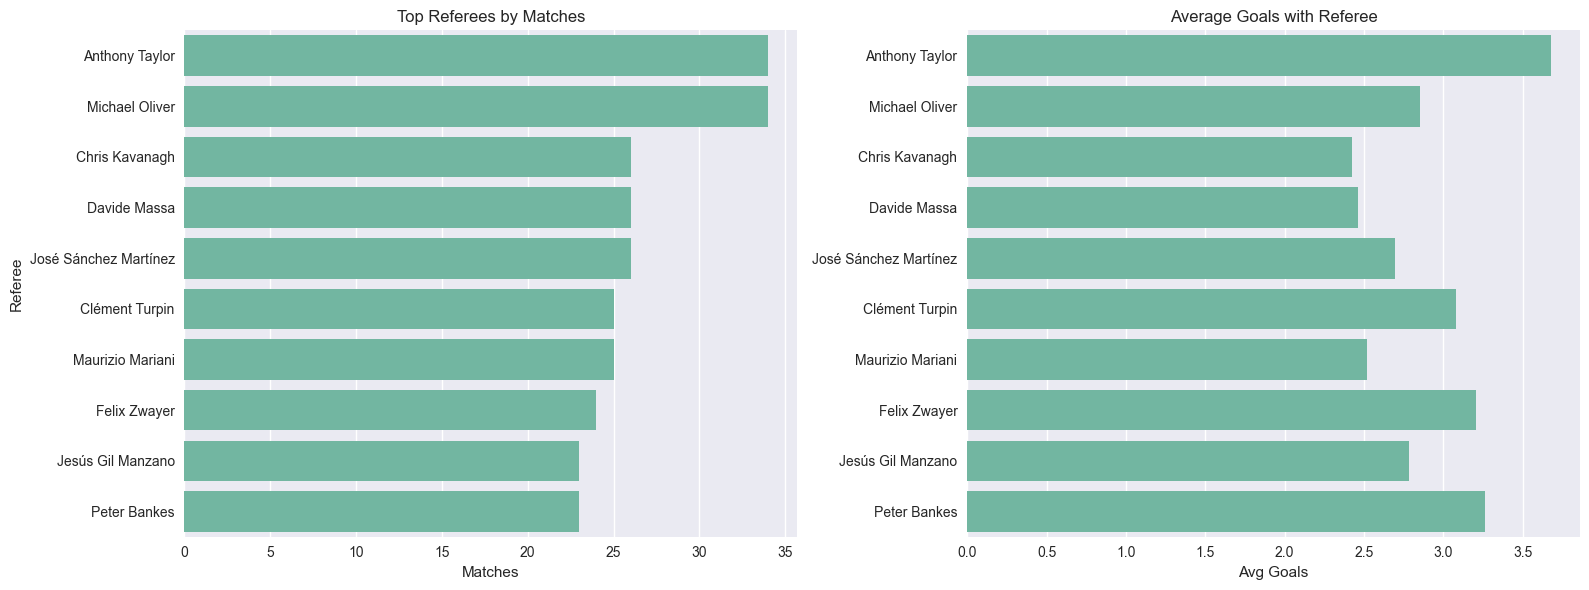

In [609]:
top_refs = df["referee"].value_counts().head(10).index
ref_stats = (df[df["referee"].isin(top_refs)]
             .groupby("referee")
             .agg(matches=("match_outcome","count"),
                  avg_goals=("TotalGoals","mean"))
             .sort_values("matches", ascending=False))

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x=ref_stats["matches"].values, y=ref_stats.index, ax=ax[0])
ax[0].set_title("Top Referees by Matches"); ax[0].set_xlabel("Matches"); ax[0].set_ylabel("Referee")

sns.barplot(x=ref_stats["avg_goals"].values, y=ref_stats.index, ax=ax[1])
ax[1].set_title("Average Goals with Referee"); ax[1].set_xlabel("Avg Goals"); ax[1].set_ylabel("")
plt.tight_layout(); plt.show()


## Goal Difference by Outcome

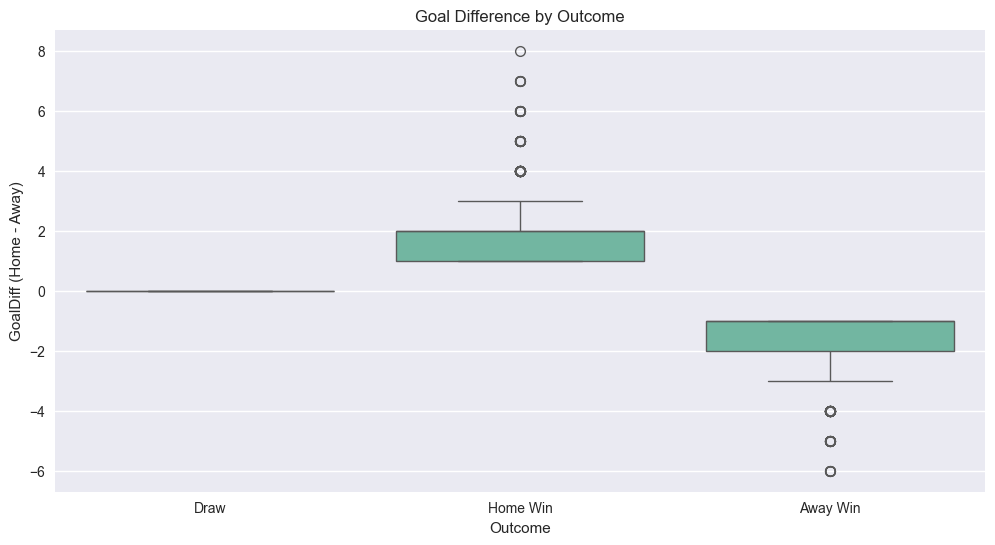

In [610]:
sns.boxplot(data=df, x="match_outcome", y="GoalDiff")
plt.title("Goal Difference by Outcome"); plt.xlabel("Outcome"); plt.ylabel("GoalDiff (Home - Away)")
plt.show()


## Home vs Away goals

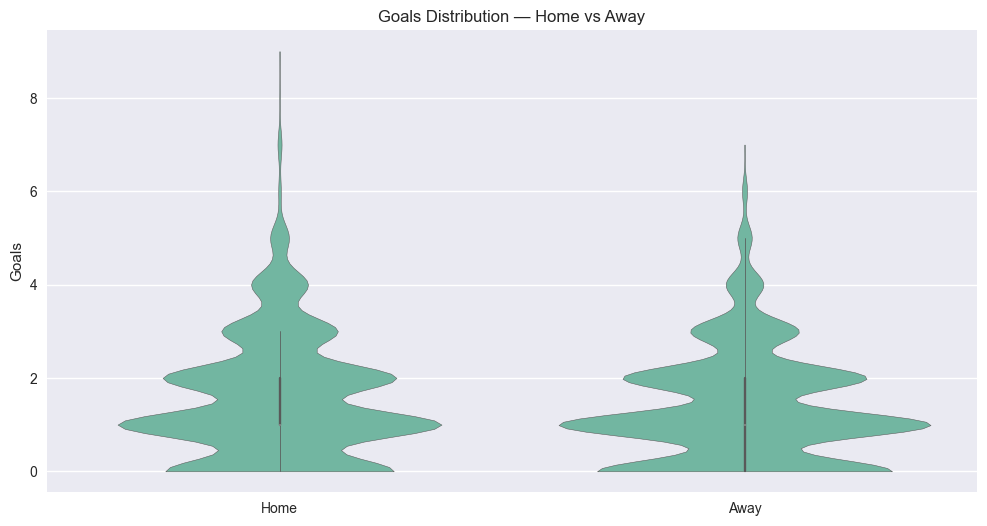

In [611]:
goals_melt = pd.melt(
    df[["fulltime_home","fulltime_away"]],
    value_vars=["fulltime_home","fulltime_away"],
    var_name="side", value_name="goals"
).replace({"fulltime_home": "Home", "fulltime_away": "Away"})
sns.violinplot(data=goals_melt, x="side", y="goals", inner="box", cut=0)
plt.title("Goals Distribution — Home vs Away"); plt.xlabel(""); plt.ylabel("Goals")
plt.show()

## Clean Sheets

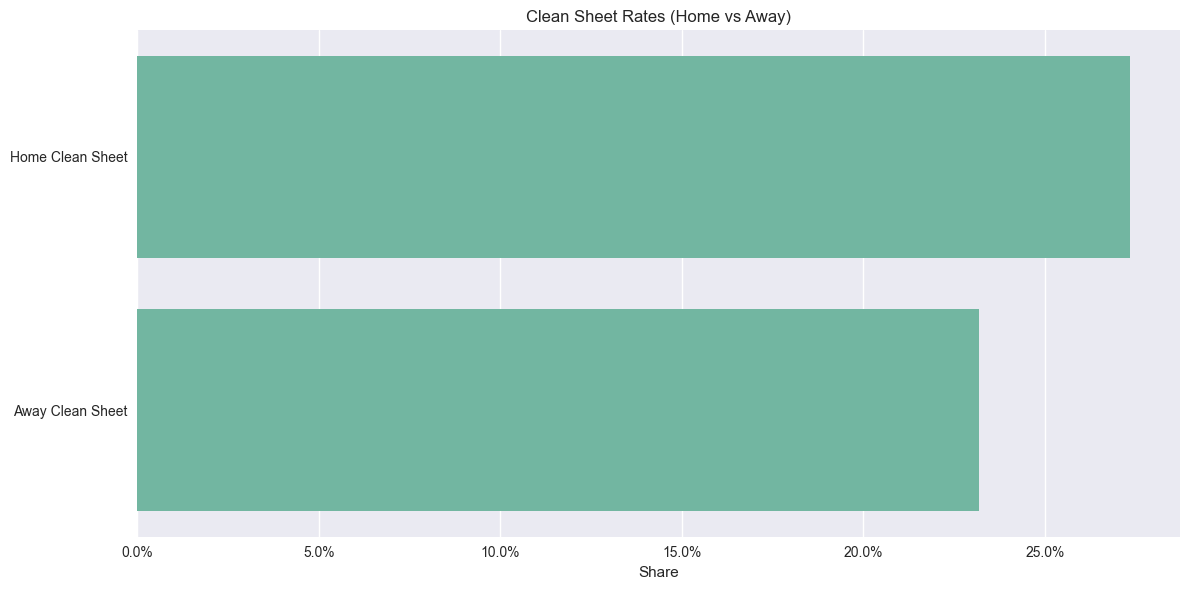

In [612]:
cs_rates = pd.DataFrame({
    "Home Clean Sheet": [df["home_cs"].mean()],
    "Away Clean Sheet": [df["away_cs"].mean()]
}).T.rename(columns={0:"rate"}).sort_values("rate", ascending=False)

ax = sns.barplot(x=cs_rates["rate"].values, y=cs_rates.index)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Clean Sheet Rates (Home vs Away)")
plt.xlabel("Share"); plt.ylabel("")
plt.tight_layout(); plt.show()


## Clean Sheet Rates by Competition (Home vs Away)

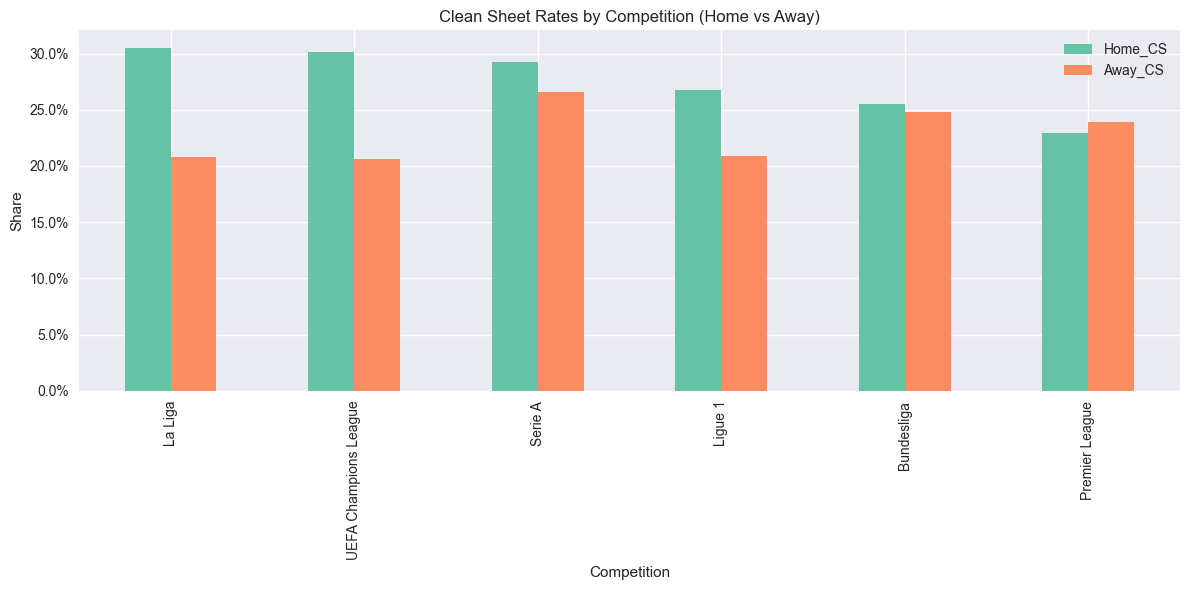

In [613]:
cs_comp = (df.groupby("competition_name")
          .agg(Home_CS=("home_cs","mean"), Away_CS=("away_cs","mean"))
          .sort_values("Home_CS", ascending=False))

ax = cs_comp.plot(kind="bar", figsize=(12,6))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Clean Sheet Rates by Competition (Home vs Away)")
plt.ylabel("Share"); plt.xlabel("Competition")
plt.tight_layout(); plt.show()


## Comeback Rate After Half-time

Full comebacks: 17.1% | Salvaged draws from behind: 10.9%


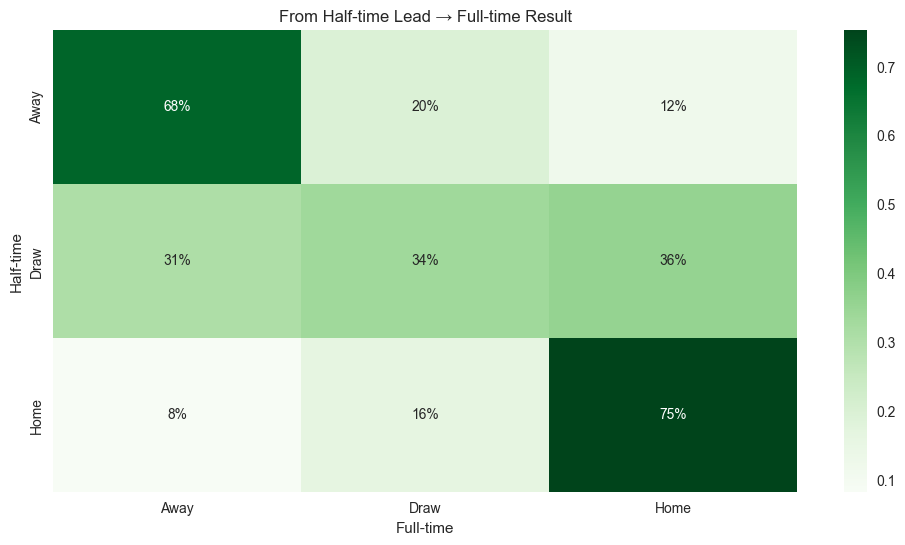

In [614]:
if {"halftime_home","halftime_away"}.issubset(df.columns):
    # Drop rows missing HT info for this analysis only
    ht = df.dropna(subset=["halftime_home","halftime_away"]).copy()
    lead_ht = np.sign(ht["halftime_home"] - ht["halftime_away"]).map({1:"Home",-1:"Away",0:"Draw"})
    lead_ft = np.sign(ht["fulltime_home"] - ht["fulltime_away"]).map({1:"Home",-1:"Away",0:"Draw"})
    tmp = pd.DataFrame({"lead_ht":lead_ht, "lead_ft":lead_ft})

    comeback = ((tmp["lead_ht"].isin(["Home","Away"])) & (tmp["lead_ht"] != tmp["lead_ft"])).mean()
    draw_from_behind = ((tmp["lead_ht"].isin(["Home","Away"])) & (tmp["lead_ft"]=="Draw")).mean()
    print(f"Full comebacks: {comeback:.1%} | Salvaged draws from behind: {draw_from_behind:.1%}")

    tab = pd.crosstab(tmp["lead_ht"], tmp["lead_ft"], normalize="index").fillna(0)
    sns.heatmap(tab, annot=True, fmt=".0%", cmap="Greens")
    plt.title("From Half-time Lead → Full-time Result"); plt.xlabel("Full-time"); plt.ylabel("Half-time")
    plt.show()

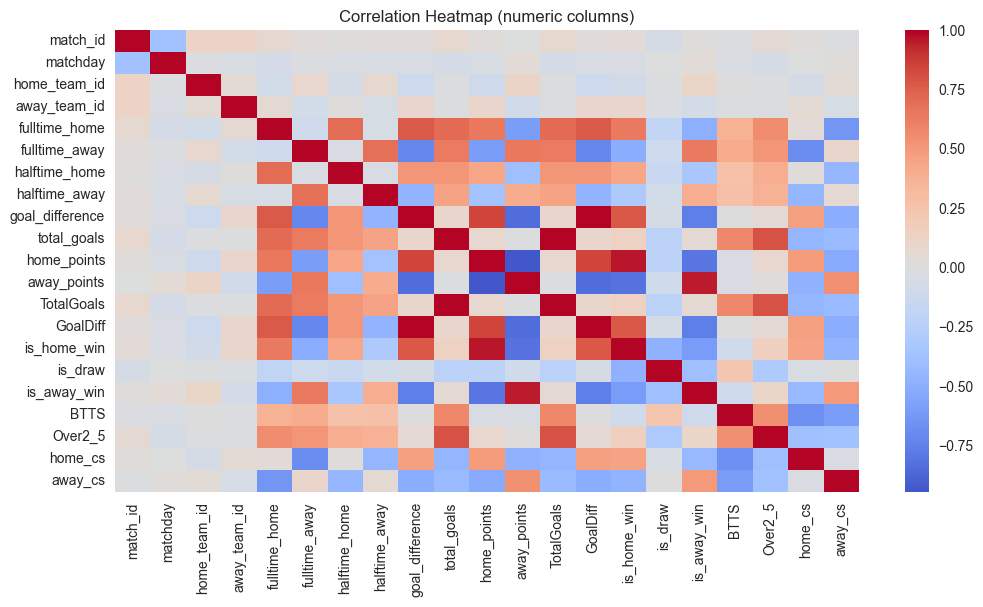

In [615]:
num_cols = df.select_dtypes(include=np.number)
corr = num_cols.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (numeric columns)")
plt.show()


## Key Takeaways

- Goal distribution varies across competitions; some have higher BTTS and Over 2.5 rates.
- Home advantage is pronounced in certain competitions (higher home win rate).
- Monthly patterns matter: BTTS/Over 2.5 rates fluctuate throughout the season.
- Top vs Bottom highlights a large offensive disparity between teams.
- First-half results don’t decide everything: comebacks happen (when HT data is available).
